# Avaliando os resultados do gridsearch

Ajustamos os hiperparâmetros do BERTopic partindo da recomendação da própria documentação da biblioteca, que aponta o min_cluster_size (ou min_topic_size) como “o parâmetro mais importante da HDBSCAN”, responsável direto pelo número e pela granularidade dos tópicos gerados. Para justificar a ênfase nessa variável recorremos ainda ao trabalho de Huiying Yan e Yu Zhang, que demonstrou correlação monotónica forte entre o coeficiente de silhueta dos clusters e a coerência temática (c_v) e propôs maximizar essa coerência iterando exclusivamente sobre min_cluster_size, obtendo ganho de 12,24 % em relação à configuração padrão \cite{yan2023optimized, grootendorst2025bertopic}.

Com base nessas evidências adotámos um procedimento em duas etapas. Na primeira realizámos uma busca ampla com passos maiores para reconhecer a região de interesse — definimos n_neighbors no intervalo de 3 a 13 (passo 2) e min_cluster_size de 10 a 50 (passo 5). Essa exploração revelou que valores acima de 25 comprimiam a variedade temática do corpus a apenas dois tópicos, inadequados à heterogeneidade esperada. Na segunda etapa restringimos a grade ao intervalo informativo identificado e refinámos a pesquisa com passo 1: n_neighbors de 3 a 14 e min_cluster_size de 10 a 24. Para cada combinação calculámos c_v, c_npmi, u_mass e diversidade, testando dois espaços de embeddings — o modelo multilingue paraphrase-MiniLM recomendado pela biblioteca e o ibm-granite. Conforme a premissa de variabilidade temática já apresentada por \cite{de2024analise}, optamos pela escolha de modelo melhor balanço entre a granularidade dos tópicos identificados e a manutenção de altos valores de coerênica (c_v). Desta forma, optamos por filtrar apenas os modelos que resultaram em pelo menos cinco tópicos, com valor de c_v dentre os 25% melhores, bem como com valor de diversity acima de 0,9.A partir desta seleção foi realizada avaliação humana dos tópicos gerados a partir da avaliação visual dos termos representativos e dos três documentos mais representativos de cada tópico.

Os critérios estabelecidos foram atendidos apenas pelos experimentos com o modelo de embedding ibm-granite. Os resultados estão disponívies na \table{}. Foram selecionados para análise os quatro primeiros registros, com maior número de tópicos. Dentre estes, foi selecionado o segundo resultado, com configuração de n_neighbors=12 e cluster_size=13. Em comparativo com as demais configurações testadas encontrou-se nele um equilíbrio entre diversidade temática e consonância dos tópicos identificados com a documentação que os compõe. Foi relevante também à análise o fato das demais configurações avaliadas apresentarem grande concentração de documentos em um número reduzido de tópicos, que não representava bem a diversidade de temáticas identificada nos documentos neles presentes.

In [ ]:
metrics = pd.read_csv('/home/th/Documentos/tm_code/tm_profiap/bertopic-pos/models/expr_granite/metrics_by_cluster_size.csv')
metrics = metrics[(metrics.diversity >= 0.9) & (metrics.n_topics >= 5)].sort_values('n_topics', ascending=False).head(10)
metrics

,n_neighbors,cluster_size,n_topics,c_v,c_npmi,u_mass,diversity
72,12,16,18,0.436378,-0.141033,-8.287199,0.916667
42,12,13,16,0.431022,-0.137693,-7.954954,0.906250
76,10,16,10,0.417016,-0.163977,-9.010575,0.920000
61,10,15,10,0.425506,-0.140617,-8.232628,0.920000
59,4,14,8,0.468689,-0.100962,-6.482566,0.925000
62,4,15,7,0.487625,-0.085510,-6.613538,0.942857
176,4,24,6,0.462606,-0.110724,-7.030296,0.950000
165,4,23,6,0.471180,-0.104323,-6.922132,0.916667
43,6,13,6,0.489936,-0.097633,-6.000570,0.966667
148,4,22,6,0.467277,-0.126489,-7.134820,0.900000


In [21]:
metrics = pd.read_csv('/home/th/Documentos/tm_code/tm_profiap/bertopic-pos/models/expr_paraphrase/metrics_by_cluster_size.csv')
metrics = metrics[ (metrics.diversity >= 0.9) & (metrics.n_topics >= 5)].sort_values('n_topics', ascending=False).head(10)
metrics

,n_neighbors,cluster_size,n_topics,c_v,c_npmi,u_mass,diversity
15,7,11,7,0.398152,-0.151040,-7.530934,0.914286
28,7,12,7,0.381588,-0.156526,-7.379791,0.900000
41,7,13,7,0.389301,-0.159685,-7.536247,0.914286
45,5,13,5,0.391888,-0.116225,-5.987229,0.960000
121,6,20,5,0.378947,-0.256896,-10.352878,0.920000
128,9,20,5,0.347220,-0.249708,-10.425087,0.920000
150,9,22,5,0.351243,-0.269337,-10.112587,0.900000
152,6,22,5,0.326145,-0.287695,-11.456812,0.920000
156,9,23,5,0.374350,-0.277378,-10.857604,0.900000
172,9,24,5,0.360608,-0.225163,-7.796587,0.920000


In [1]:
# Imports e caminhos
from pathlib import Path
import json, pandas as pd, random, numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
import spacy, gensim
from spacy.lang.pt.stop_words import STOP_WORDS as STOP_PT
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

ROOT = Path('/home/th/Documentos/tm_code/tm_profiap/bertopic-pos')
DATA_DIR   = ROOT / 'data'
MODEL_DIR  = ROOT / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Carregar dados e pré-processar
CSV_PATH = DATA_DIR / 'raw' / 'dissertacoes_profiap_14_23.csv'  # ajuste se precisar
df = pd.read_csv(CSV_PATH).drop_duplicates("DS_RESUMO")
docs = df["DS_RESUMO"].fillna("").tolist()
nlp  = spacy.load('pt_core_news_sm', disable=['ner', 'parser'])
def preprocess(doc):
    return ' '.join([t.lemma_.lower() for t in nlp(doc) if t.is_alpha and not t.is_stop])
docs_pp = [preprocess(d) for d in docs]
# emb_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
emb_model = SentenceTransformer(
    "ibm-granite/granite-embedding-278m-multilingual",
    trust_remote_code=True          # requerido porque o código customizado está no repo
)
embeddings = emb_model.encode(docs_pp, show_progress_bar=True)

EXTRA_SW = {
    "universidade federal","universidade","federal","pesquisa","análise","estudo",
    "objetivo","resultado","brasil","dados","ações","processo","público","pública",
    # siglas UF...
    "UFG","UFMS","UFGD","UFMT","FURG","UFPel","UTFPR","UNIPAMPA","UFFS","UFV",
    "UNIFAL","UFJF","UFSJ","UFTM","UFF","UFMG","UNIFESP","UFU","UNIR","UFT",
    "UFAC","UFAM","UNIFESSPA","UFOPA","UFRR","UFRA","UFAL","UFS","UFCG","UFERSA",
    "UFRPE","UNIVASF","UFPI","UFC","UFCA","UNILAB","UFDPar","UFMA","UFRN","UFPB",
}

STOPWORDS = STOP_PT.union(EXTRA_SW)

nlp = spacy.load("pt_core_news_sm", disable=["parser", "ner"])
nlp.max_length = 3_000_000

def spacy_tokenizer(text):
    doc = nlp(text)
    return [t.lemma_.lower() for t in doc
            if t.is_alpha and len(t) > 3
            and t.lemma_.lower() not in STOPWORDS]

vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, stop_words=list(STOPWORDS), max_df=0.9)

# Representação
representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "MMR": MaximalMarginalRelevance(diversity=0.3),
}

/home/th/.cache/pypoetry/virtualenvs/tm-profiap-C5jsyTuW-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]


In [2]:
# Loop de treinamento
N_NEIGHBORS = [12]
CLUSTER_SIZES = [13]
results = []
counter = 0
for n in N_NEIGHBORS:
    umap_model = UMAP(n_neighbors=n, random_state=SEED)
    for m in CLUSTER_SIZES:
        counter+=1
        hdbscan_model = HDBSCAN(min_cluster_size=m,
                                metric="euclidean",
                                cluster_selection_method="eom",
                                prediction_data=False)

        topic_model = BERTopic(embedding_model=emb_model,
                               umap_model=umap_model,
                               hdbscan_model=hdbscan_model,
                               vectorizer_model=vectorizer,
                               representation_model=representation_model,
                               top_n_words=10,
                               verbose=False)

        topics, _ = topic_model.fit_transform(docs_pp, embeddings)


In [3]:
topic_info = topic_model.get_topic_info()
topic_info.to_csv('/home/th/Documentos/tm_code/tm_profiap/notebooks/topic_info.csv')
topic_info

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,344,-1_comunicação_município_projeto_qualidade,"[comunicação, município, projeto, qualidade, r...","[governamental, governo, accountability, orçam...","[comunicação, município, projeto, qualidade, a...",[movimento modernização gestão pública curso m...
1,0,315,0_competência_avaliação_planejamento_curso,"[competência, avaliação, planejamento, curso, ...","[universitário, avaliação, graduação, prestaçã...","[competência, avaliação, capacitação, gerencia...",[trabalho apresenta estudo caso avaliações in ...
2,1,118,1_sustentável_ambiental_sustentabilidade_resíduo,"[sustentável, ambiental, sustentabilidade, res...","[sustentabilidade, sustentável, ambiental, soc...","[sustentável, ambiental, sustentabilidade, res...",[consciência percepção profundidade problemas ...
3,2,68,2_eficiência_município_financeiro_orçamentário,"[eficiência, município, financeiro, orçamentár...","[eficiência, eficácia, orçamento, despesa, orç...","[eficiência, fiscal, gasto, orçamento, custo, ...",[estudos eficiência setor público presentes tr...
4,3,65,3_participativo_municipal_democrático_democracia,"[participativo, municipal, democrático, democr...","[institucionalização, governança, participativ...","[participativo, municipal, democrático, consti...",[haja vista processo redemocratização brasil a...
5,4,63,4_saúde_satisfação_comprometimento_qualidade,"[saúde, satisfação, comprometimento, qualidade...","[laboral, ocupacional, exame, funcionário, cam...","[saúde, satisfação, qualidade, dimensão, afeti...",[tema qualidade vida trabalho qvt presente dis...
6,5,55,5_compra_licitação_contratação_aquisição,"[compra, licitação, contratação, aquisição, pr...","[compra, licitação, aquisição, licitatório, li...","[licitação, contratação, aquisição, licitatóri...",[realizar processo compras públicas economicam...
7,6,42,6_teletrabalho_remoto_pandemia_produtividade,"[teletrabalho, remoto, pandemia, produtividade...","[teletrabalho, teletrabalhador, laboral, traba...","[teletrabalho, remoto, pandemia, presencial, l...",[março mundo passou conviver oficialmente pand...
8,7,30,7_contrato_terceirização_fiscalização_terceirizar,"[contrato, terceirização, fiscalização, tercei...","[fiscalização, fiscalizar, burocrático, fiscal...","[contrato, terceirização, fiscal, contratação,...",[gestão fiscalização contratos aspectos essenc...
9,8,27,8_inovação_tecnológico_patente_tecnologia,"[inovação, tecnológico, patente, tecnologia, n...","[inovação, inovador, inova, inovadoro, invençã...","[inovação, tecnológico, patente, empresa, impa...",[cooperação representa importante fator inovaç...


In [39]:
barchart = topic_model.visualize_barchart(top_n_topics=16, n_words=5,autoscale=True)

In [41]:
import plotly.io as pio
pio.write_html(
    barchart,
    file="/home/th/Documentos/tm_code/tm_profiap/notebooks/barchart_profiap.html",
    full_html=False,          # inclui <html>…<script> do Plotly
    include_plotlyjs="cdn"   # carrega JS de um CDN → arquivo menor
)

In [44]:
topics_over_time = topic_model.topics_over_time(docs, timestamps=df['AN_BASE'],)
tot = topic_model.visualize_topics_over_time(topics_over_time)

pio.write_html(
    tot,
    file='/home/th/Documentos/tm_code/tm_profiap/notebooks/topics_over_time.html',
    full_html=True,          # inclui <html>…<script> do Plotly
    include_plotlyjs="cdn",   # carrega JS de um CDN → arquivo menor
    default_width= "90%"
    
)

<InteractiveFigure width=1200 height=750>
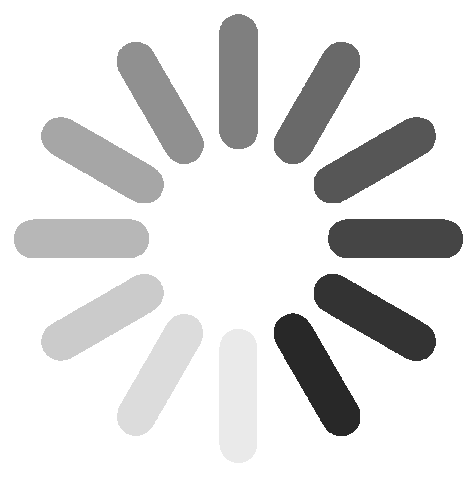

In [ ]:
import datamapplot
reduced_embeddings = UMAP().fit_transform(embeddings)
datamap = topic_model.visualize_document_datamap(docs=docs,reduced_embeddings=reduced_embeddings, interactive=True, enable_search=True, title='Documentos e Tópicos - Dissertações PROFIAP')
datamap.save("/home/th/Documentos/datamap_profiap.html")

In [45]:
import textwrap
for i in topic_model.get_representative_docs(topic=12):
    print(textwrap.fill(i, width=160))
    print('\n\n')

organizações públicas privadas passaram transformações longo tentando acompanhar dinamismo relações sociais tempos remotos capital importante organizações
relacionado ativos tangíveis bens materiais imóveis entanto últimos anos atenções capital humano considerando contexto mudanças valorização capital humano nasce
sociedade conhecimento gestão conhecimento ferramenta necessária organização organizações públicas gestão conhecimento ganha importância medida mudanças trazem
necessidade aumento eficiência eficácia prestação serviços cenário presente estudo busca identificar dificuldades vivenciadas servidores universidade federal
rural semiárido mudança setor ferramentas utilizadas melhorar compartilhamento conhecimento instituição investigadas práticas compartilhamento conhecimento
atividades administrativas atores barreiras facilitadores conhecimento natureza metodológica pesquisa qualitativa procedimento estudo caso coleta dados
realizada entrevistas semiestruturadas servidores institui

In [61]:
# Imports e caminhos
from pathlib import Path
import pandas as pd, random, numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS as STOP_PT
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

ROOT = Path('/home/th/Documentos/tm_code/tm_profiap/bertopic-pos')
DATA_DIR   = ROOT / 'data'
MODEL_DIR  = ROOT / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Carregar dados e pré-processar
CSV_PATH = DATA_DIR / 'raw' / 'dissertacoes_profiap_14_23.csv'  # ajuste se precisar
df = pd.read_csv(CSV_PATH).drop_duplicates("DS_RESUMO")
docs = df["DS_RESUMO"].fillna("").tolist()
nlp  = spacy.load('pt_core_news_sm', disable=['ner', 'parser'])
def preprocess(doc):
    return ' '.join([t.lemma_.lower() for t in nlp(doc) if t.is_alpha and not t.is_stop])
docs_pp = [preprocess(d) for d in docs]
emb_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
embeddings = emb_model.encode(docs_pp, show_progress_bar=True)

EXTRA_SW = {
    "universidade federal","universidade","federal","pesquisa","análise","estudo",
    "objetivo","resultado","brasil","dados","ações","processo","público","pública",
    # siglas UF...
    "UFG","UFMS","UFGD","UFMT","FURG","UFPel","UTFPR","UNIPAMPA","UFFS","UFV",
    "UNIFAL","UFJF","UFSJ","UFTM","UFF","UFMG","UNIFESP","UFU","UNIR","UFT",
    "UFAC","UFAM","UNIFESSPA","UFOPA","UFRR","UFRA","UFAL","UFS","UFCG","UFERSA",
    "UFRPE","UNIVASF","UFPI","UFC","UFCA","UNILAB","UFDPar","UFMA","UFRN","UFPB",
}

STOPWORDS = STOP_PT.union(EXTRA_SW)

nlp = spacy.load("pt_core_news_sm", disable=["parser", "ner"])
nlp.max_length = 3_000_000

def spacy_tokenizer(text):
    doc = nlp(text)
    return [t.lemma_.lower() for t in doc
            if t.is_alpha and len(t) > 3
            and t.lemma_.lower() not in STOPWORDS]

vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, stop_words=list(STOPWORDS), max_df=0.9)

# Redução de dimensionalidade

# Representação
representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "MMR": MaximalMarginalRelevance(diversity=0.3),
}

Batches: 100%|██████████| 40/40 [00:02<00:00, 15.51it/s]


In [ ]:
# Loop de treinamento
N_NEIGHBORS = [7]
CLUSTER_SIZES = [11]
results = []
counter = 0
for n in N_NEIGHBORS:
    umap_model = UMAP(n_neighbors=n, random_state=SEED)
    for m in CLUSTER_SIZES:
        counter+=1
        hdbscan_model = HDBSCAN(min_cluster_size=m,
                                metric="euclidean",
                                cluster_selection_method="eom",
                                prediction_data=False)

        topic_model = BERTopic(embedding_model=emb_model,
                               umap_model=umap_model,
                               hdbscan_model=hdbscan_model,
                               vectorizer_model=vectorizer,
                               representation_model=representation_model,
                               top_n_words=10,
                               verbose=False)

        topics, _ = topic_model.fit_transform(docs_pp, embeddings)


AttributeError: 'BERTopic' object has no attribute 'info'

In [85]:
!poetry install datamapplot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Poetry could not find a pyproject.toml file in /home/th/Documentos/tm_code or its parents


In [20]:
topic_model.visualize_heatmap()